![](https://www.ishn.com/ext/resources/Issues/2019/06-June/ISHN0619_C2_pic.jpg?1559575718)



<div align="center" style="font-size:14px;">
    <h1><strong>Infectious diseases prediction (2001-2014)</strong></h1>
</div>

<div align="center" style="font-size:14px;">
  <h2>Introduction and description of the data and the project</h2>
</div>

This project's objective is to use a machine learning and data mining algorithms that predict whether a person in a given county is likely to have a specific infectious disease based on a data from a dataset from Kaggle called [Infectious Disease 2001-2004](https://www.kaggle.com/datasets/jahaidulislam/infectious-disease-2001-2014).

Infectious diseases, caused by pathogens like viruses, bacteria, fungi, and parasites, spread through various means including direct contact, droplets, airborne particles, and contaminated food or water. These diseases significantly impact public health and the global economy, with varying incidence and prevalence across different regions and populations over time.

The dataset tracks outbreaks by year and state, detailing the location, type, duration, and demographic information of affected individuals, such as age, gender, and race. It also includes information on the suspected or confirmed pathogens, modes of transmission, and outbreak sources, covering a range of diseases like foodborne illnesses, respiratory infections, and sexually transmitted infections.

Dataset Features:
*   Disease
*   County
*   Year
*   Sex
*   Count
*   Population
*   Rate
*   CI.lower
*   CI.upper
*   Unstable

<div align="center" style="font-size:14px;">
  <h1>Importing the needed libraries</h1>
</div>

In [21]:
# Loading of data
import pandas as pd # pd is an alias for pandas library
import numpy as np
pd.options.mode.copy_on_write = True # When performing certain operations on a pandas DataFrame, it may create copies of the data even if the operation does not actually modify the data. That's why we use this configuration option for the pandas library that helps manage how data is copied.

# Visualization of data
import matplotlib.pyplot as plt
import seaborn as sns # aesthetics of plots

# Data splitting
from sklearn.model_selection import train_test_split, cross_val_score
# Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Perceptron
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, precision_score, recall_score,  precision_recall_fscore_support, f1_score
# Standardization 
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.pipeline import make_pipeline

<div align="center" style="font-size:14px;">
  <h1>Loading of dataset</h1>
</div>

In [22]:
my_df = pd.read_csv('/kaggle/input/infectious-disease-2001-2014/Infectious Disease 2001-2014.csv')
my_df.head()


,Disease,County,Year,Sex,Count,Population,Rate,CI.lower,CI.upper,Unstable
0,Amebiasis,California,2001,Total,571,34514777,1.654,1.521,1.796,
1,Amebiasis,California,2001,Female,176,17340743,1.015,0.871,1.176,
2,Amebiasis,California,2001,Male,365,17174034,2.125,1.913,2.355,
3,Amebiasis,California,2002,Total,442,34940334,1.265,1.150,1.389,
4,Amebiasis,California,2002,Female,145,17555714,0.826,0.697,0.972,


<div align="center" style="font-size:14px;">
  <h1>Data analysis and visualization</h1>
</div>

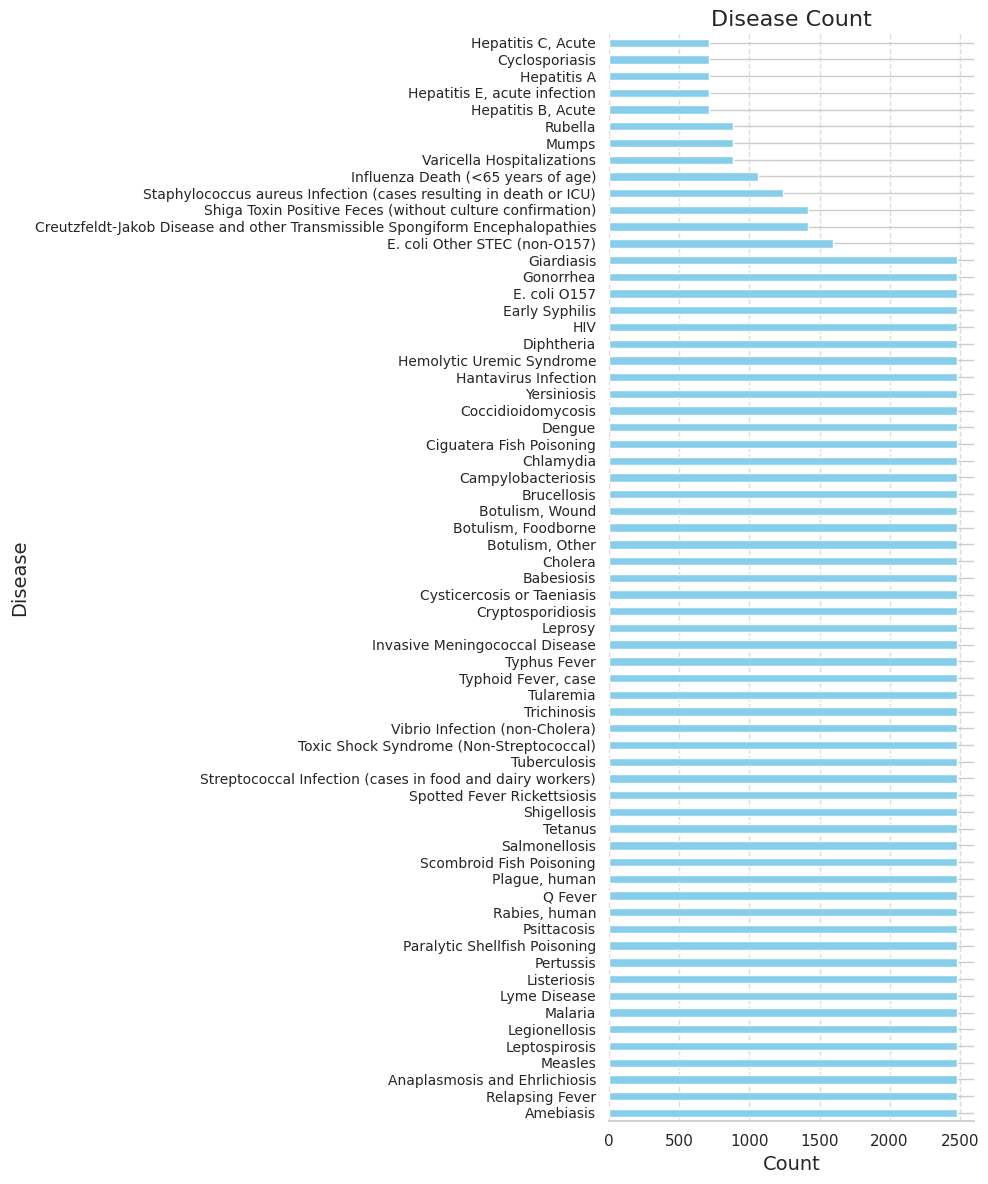

In [23]:
# The same plot, but with this code it is not clear and readable
# my_df['Disease'].value_counts().plot(kind='barh')
# plt.xlabel('Count')
# plt.ylabel('Disease')
# plt.title('Disease Count')
# plt.show()

# Setting the aesthetic style of the plots to a "whitegrid" style, which adds a white background with grid lines 
# and makes the plots cleaner and easier to read
sns.set(style="whitegrid") 
# Creating the plot
plt.figure(figsize=(10, 12)) #10 width 12 height
my_df['Disease'].value_counts().plot(kind='barh', color='skyblue') #This counts the occurrences of each 
# unique value in the 'Disease' column and makes a horizontal bar chart

# Adding labels and title
plt.xlabel('Count', fontsize=14)
plt.ylabel('Disease', fontsize=14)
plt.title('Disease Count', fontsize=16)

# Rotating y-axis labels for better readability and setting the font size of the labels 
plt.yticks(fontsize=10) 

# Adding grid lines along the x-axis with a dashed line style and a transparency of 0.7. 
# Grid lines can help in aligning and comparing the values.
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Removing frame to make it cleaner
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Showing the plot
plt.tight_layout() #: This ensures that everything fits into the figure area neatly.
plt.show()

In [24]:
# Computing and displaying summary statistics for numerical columns in the dataframe my_df. 
# It's useful for getting a high-level overview of the data.
my_df.describe()

,Year,Count,Population,Rate,CI.lower,CI.upper
count,141777.000000,141777.000000,1.417770e+05,141777.000000,141777.000000,141777.000000
mean,2007.857678,81.368438,8.299702e+05,6.984715,5.726249,28.912777
std,4.052999,1954.637660,3.452198e+06,44.861027,41.479404,87.209601
min,2001.000000,0.000000,5.330000e+02,0.000000,0.000000,0.010000
25%,2004.000000,0.000000,2.871500e+04,0.000000,0.000000,1.495000
50%,2008.000000,0.000000,1.239460e+05,0.000000,0.000000,5.233000
75%,2011.000000,1.000000,4.119620e+05,0.203000,0.010000,17.814000
max,2014.000000,174557.000000,3.850149e+07,1020.550000,992.007000,1632.966000


Column: Disease, Type: object
Skipping non-numeric column: Disease
Column: County, Type: object
Skipping non-numeric column: County
Column: Year, Type: int64


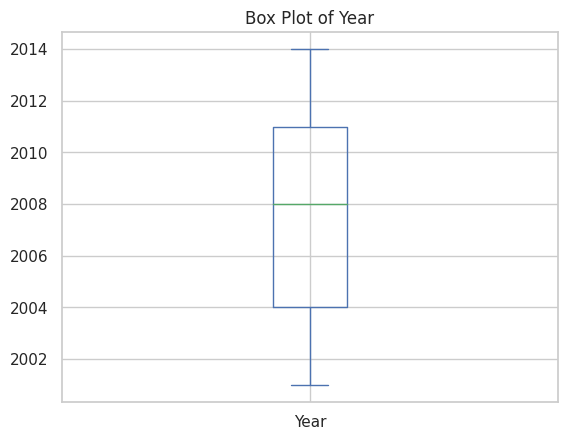

Column: Sex, Type: object
Skipping non-numeric column: Sex
Column: Count, Type: int64


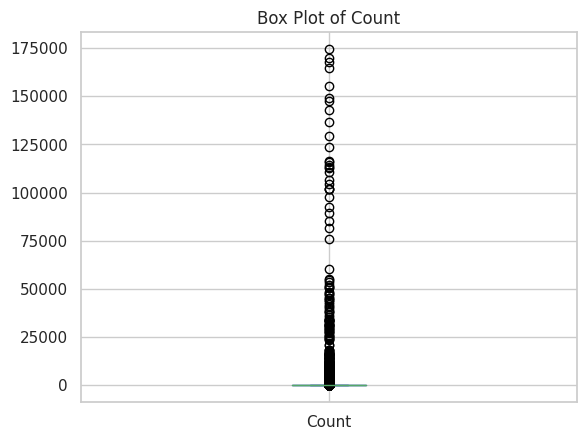

Column: Population, Type: int64


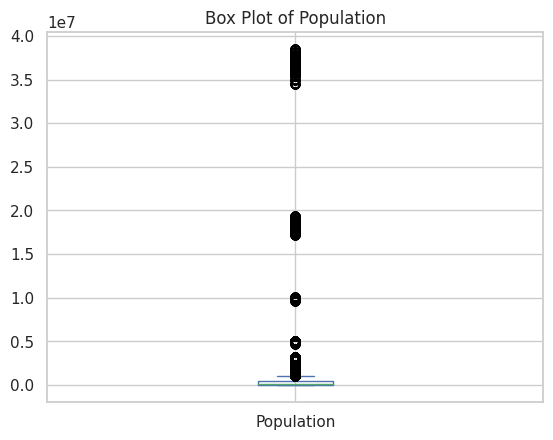

Column: Rate, Type: float64


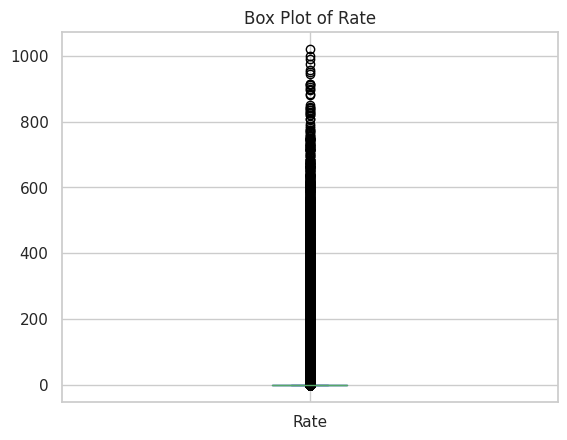

Column: CI.lower, Type: float64


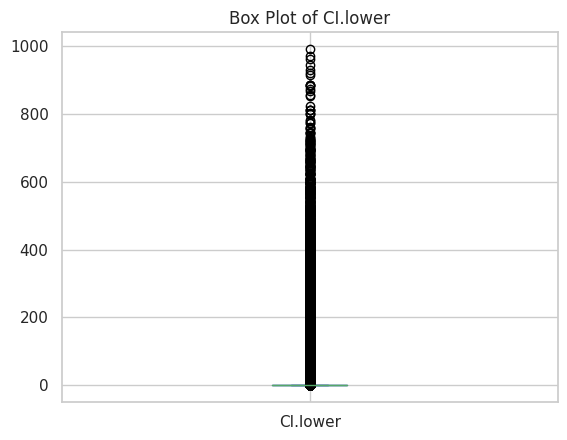

Column: CI.upper, Type: float64


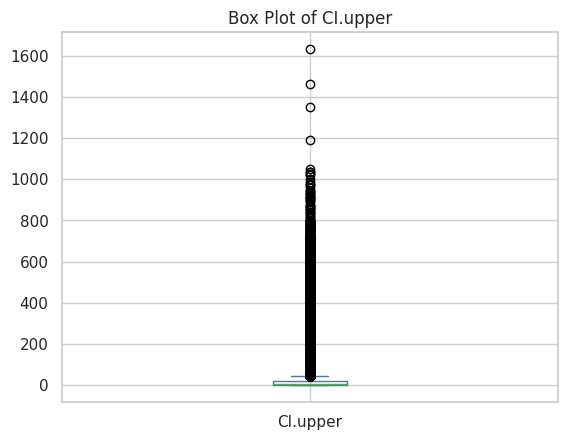

In [25]:
# Checking the distribution of the values and identifying potential outliers
for col in my_df.columns[0:-1]:
    # Print column name and type
    print(f"Column: {col}, Type: {my_df[col].dtype}")
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(my_df[col]):
        my_df[col].plot.box(title=f"Box Plot of {col}")
        plt.show()
    else:
        print(f"Skipping non-numeric column: {col}")

<p style="font-size:14px;">
In the obtained box plots we can see that there are a lot of outliers (except the box plot for the column "Year"). We have to decide what should we do with them and understand if they are important for our problem solving or not. We will use <strong>log transformation</strong>.
</p>

In [26]:
def log_transform_outliers(series):
    # Defining threshold for outliers
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR

    # Applying log transformation to each value x if it exceeds the threshold. For values that are not 
    # outliers, it returns the value unchanged.
    return series.apply(lambda x: np.log(x) if x > threshold else x)

# Creating a new DataFrame for transformed data
my_df_transformed = pd.DataFrame()

# Applying log transformation to all numeric columns and storing the resulting values in the new dataframe 
for col in my_df.select_dtypes(include=np.number):
    my_df_transformed[f'{col}_transformed'] = log_transform_outliers(my_df[col])

print("\nTransformed Dataset:")
print(my_df_transformed.head())



Transformed Dataset:
   Year_transformed  Count_transformed  Population_transformed  \
0              2001           6.347389               17.356898   
1              2001           5.170484               16.668569   
2              2001           5.899897               16.658909   
3              2002           6.091310               17.369152   
4              2002           4.976734               16.680890   

   Rate_transformed  CI.lower_transformed  CI.upper_transformed  
0          0.503197              0.419368                 1.796  
1          0.014889             -0.138113                 1.176  
2          0.753772              0.648673                 2.355  
3          0.235072              0.139762                 1.389  
4         -0.191161             -0.360970                 0.972  


Year_transformed             Axes(0.125,0.653529;0.227941x0.226471)
Count_transformed         Axes(0.398529,0.653529;0.227941x0.226471)
Population_transformed    Axes(0.672059,0.653529;0.227941x0.226471)
Rate_transformed             Axes(0.125,0.381765;0.227941x0.226471)
CI.lower_transformed      Axes(0.398529,0.381765;0.227941x0.226471)
CI.upper_transformed      Axes(0.672059,0.381765;0.227941x0.226471)
dtype: object

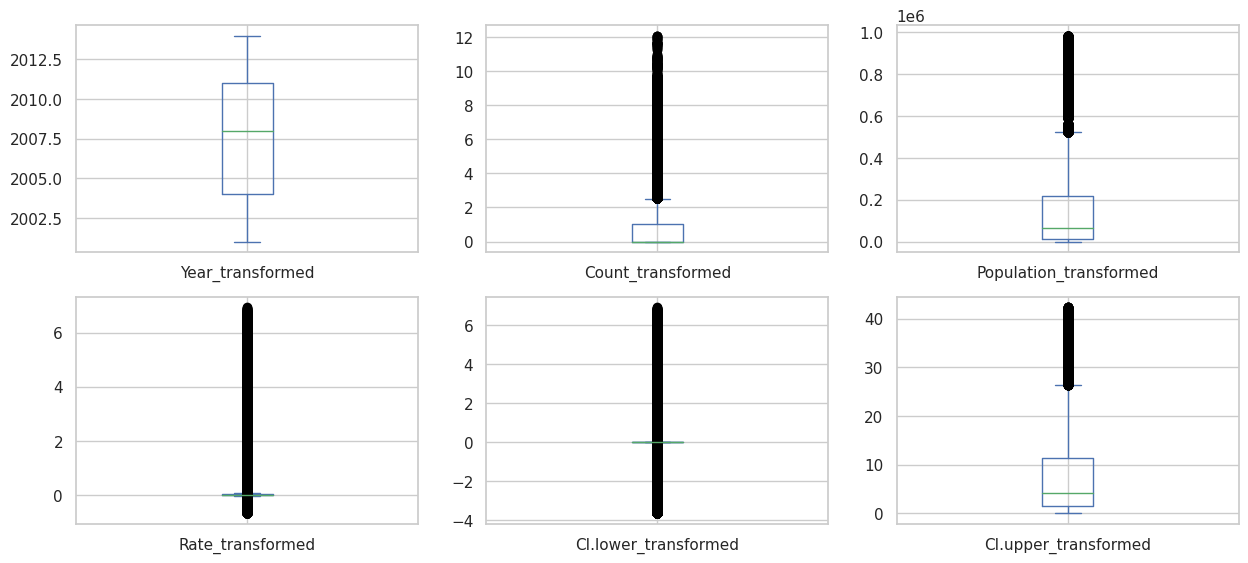

In [27]:
# Creating boxplots for the tranformed dataframe to check for improvements
my_df_transformed.plot(kind='box', subplots=True, layout=(3,3), sharex=False, figsize=(15, 10))

# subplots = True indicates that a separate subplot should be created for each column in the DataFrame. If set to False, a single plot would be created for the entire DataFrame.
# sharex = True means that each subplot will have its own x-axis. 

We can see that we have some improvement and we can proceed with working on the data. Next, we check if there are NA values and if yes, we delete them.

In [28]:
# Merging together the columns from the data frame wih improvement in outliers and the columns from the original data frame that are missing.
# Identifying common columns
common_columns = my_df.columns.intersection(my_df_transformed.columns).tolist()
# Identifying additional columns
additional_columns = my_df.columns.difference(my_df_transformed.columns).tolist()
# Selecting common columns from the data frame without outliers
df_common = my_df_transformed[common_columns]
# Selecting all columns from the data frame with outliers
df_all_columns = my_df

# Merging data frames
# I use `df_all_columns` since it contains all columns and `df_common` for the common columns
my_df_final = pd.merge(df_all_columns, df_common, how='left', left_index=True, right_index=True)

print("\nFinal DataFrame:")
print(my_df_final.head())


Final DataFrame:
     Disease      County  Year     Sex  Count  Population   Rate  CI.lower  \
0  Amebiasis  California  2001   Total    571    34514777  1.654     1.521   
1  Amebiasis  California  2001  Female    176    17340743  1.015     0.871   
2  Amebiasis  California  2001    Male    365    17174034  2.125     1.913   
3  Amebiasis  California  2002   Total    442    34940334  1.265     1.150   
4  Amebiasis  California  2002  Female    145    17555714  0.826     0.697   

   CI.upper Unstable  
0     1.796           
1     1.176           
2     2.355           
3     1.389           
4     0.972           


In [29]:
my_df_final.isna().sum()

Disease       0
County        0
Year          0
Sex           0
Count         0
Population    0
Rate          0
CI.lower      0
CI.upper      0
Unstable      0
dtype: int64

We see that we don't have NA values, so we proceed with the model selection.

<div align="center" style="font-size:14px;">
  <h1>Data splitting</h1>
</div>

In [30]:
# Encode categorical variables
my_df_encoded = my_df_final.copy() # to ensure that any modifications made to my_df_encoded do not affect the original data frame
le = LabelEncoder() #  Initializing a LabelEncoder object from the library scikit-learn. 
# It is used to convert categorical labels into numerical values. 
my_df_encoded['Sex'] = le.fit_transform(my_df_final['Sex']) # Learns the unique values present in the Sex 
# column and assigns an integer to each unique category.
my_df_encoded.head()


,Disease,County,Year,Sex,Count,Population,Rate,CI.lower,CI.upper,Unstable
0,Amebiasis,California,2001,2,571,34514777,1.654,1.521,1.796,
1,Amebiasis,California,2001,0,176,17340743,1.015,0.871,1.176,
2,Amebiasis,California,2001,1,365,17174034,2.125,1.913,2.355,
3,Amebiasis,California,2002,2,442,34940334,1.265,1.150,1.389,
4,Amebiasis,California,2002,0,145,17555714,0.826,0.697,0.972,


In [31]:
# We have a few x variables which we use to make a prediction on the y variable

# Specifying the features (independent variables) used to predict the target variable.
X = my_df_encoded[['Year', 'Sex', 'Population', 'Rate', 'CI.lower', 'CI.upper']] #or we could drop Count and Unstable from the data frame, but we have to specify axis=1 for column wise
# Target variable (dependent)
y = my_df_encoded['Count'] > 0  # Binary target: 1 if Count > 0, else 0, it is easier for machine learning models

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # I specify random_state to be a 42 to make sure that every time I run the command I will get the same data split


In [32]:
# Standardizing the features, which is a common preprocessing step that ensures all features contribute 
# equally to the model. It computes the mean and standard deviation of the features and standardizes them 
# using the computed mean and standard deviation.
numeric_features = ['Year', 'Population', 'Rate', 'CI.lower', 'CI.upper']
scaler = StandardScaler() # Creates an instance of the StandardScaler class from sklearn.preprocessing
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features]) # Standardizes the numerical features in the training data.
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features]) # Standardizes the numerical features in the testing data.

# Standardizing can lead to better model performance by improving convergence speed and stability.

<div align="center" style="font-size:14px;">
  <h1>Model selection</h1>
</div>

<div align="center" style="font-size:14px;">
  <h2>K-means clustering</h2>
</div>

**K-Means** is an unsupervised learning algorithm used for clustering. It partitions data into k clusters, where each data point belongs to the cluster with the nearest mean. 

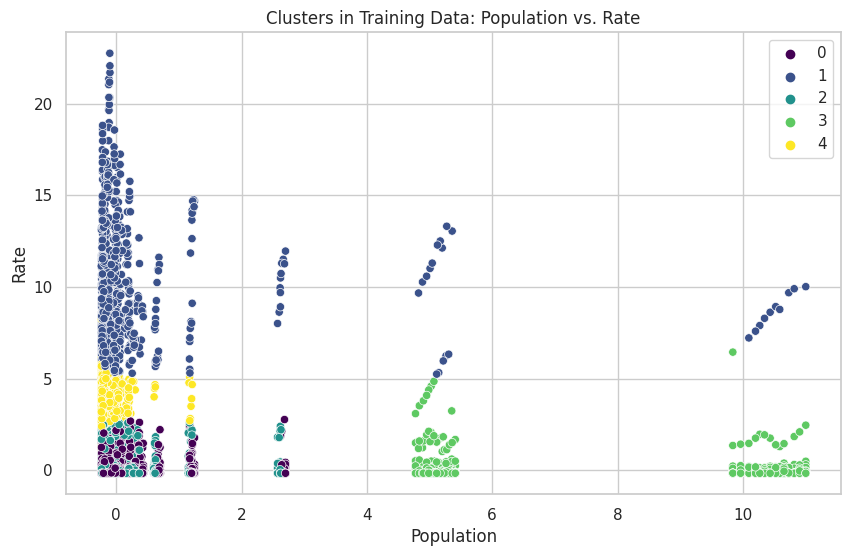

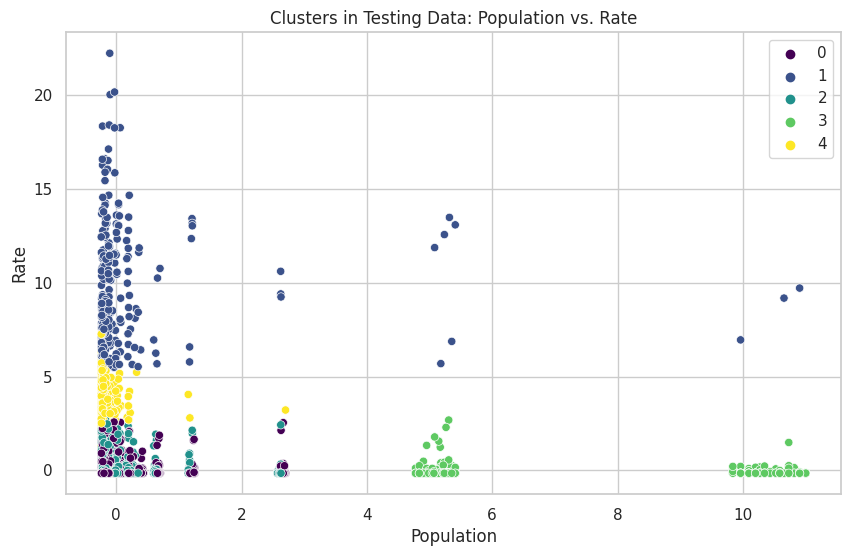

In [33]:
# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10) #n_init=10 is the number of times the K-Means 
# algorithm will be run with different centroid seeds. The final results will be the best output of these runs.
train_clusters = kmeans.fit_predict(X_train_scaled[numeric_features]) # Fits the K-Means model to the 
# training data and assigns each training sample to one of the clusters. 
# It returns the cluster labels for each sample.
test_clusters = kmeans.predict(X_test_scaled[numeric_features]) # Assigns each test sample to one of the 
# clusters determined from the training data.

# Add cluster labels to DataFrames. This allows us to analyze and visualize how the clusters are distributed across the features.
X_train_scaled['Cluster'] = train_clusters
X_test_scaled['Cluster'] = test_clusters

# Visualizing the Clusters with a Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_scaled['Population'], y=X_train_scaled['Rate'], hue=X_train_scaled['Cluster'], palette='viridis')
# hue=X_train_scaled['Cluster']: colors the points based on the cluster label from the Viridis color palette.
plt.title('Clusters in Training Data: Population vs. Rate')
plt.xlabel('Population')
plt.ylabel('Rate')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_scaled['Population'], y=X_test_scaled['Rate'], hue=X_test_scaled['Cluster'], palette='viridis')
plt.title('Clusters in Testing Data: Population vs. Rate')
plt.xlabel('Population')
plt.ylabel('Rate')
plt.legend()
plt.show()


<div align="center" style="font-size:14px;">
  <h2>Decision tree Classifier</h2>
</div>

A **Decision Tree** is a popular supervised machine learning model used for both classification and regression tasks. It is a flowchart-like structure where:
  - Nodes represent features (or attributes) of the data.
  - Edges represent decision rules.
  - Leaves represent the outcome or decision.

The model splits the dataset into subsets based on feature values, aiming to reduce uncertainty or entropy in the target variable. It does this in a hierarchical, tree-like structure where each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label or a continuous value.

Key concepts:
- Splitting: Divides the dataset into subsets based on feature values to make the subsets as homogeneous as possible.
- Entropy: Measures impurity; splits the data to reduce entropy the most.
- Gini Impurity: Another measure of impurity, indicating the probability of incorrect classification; used for splitting.
- Pruning: Removes unnecessary nodes to simplify the tree and prevent overfitting.
- Overfitting: When the model is too complex and captures noise instead of the true pattern; controlled by pruning and setting constraints like maximum depth.

Decision Tree Classifier
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20124
        True       1.00      1.00      1.00      8232

    accuracy                           1.00     28356
   macro avg       1.00      1.00      1.00     28356
weighted avg       1.00      1.00      1.00     28356

Confusion Matrix:
[[20124     0]
 [    0  8232]]
Accuracy: 1.0
Cross Validation Accuracy: 100.00%


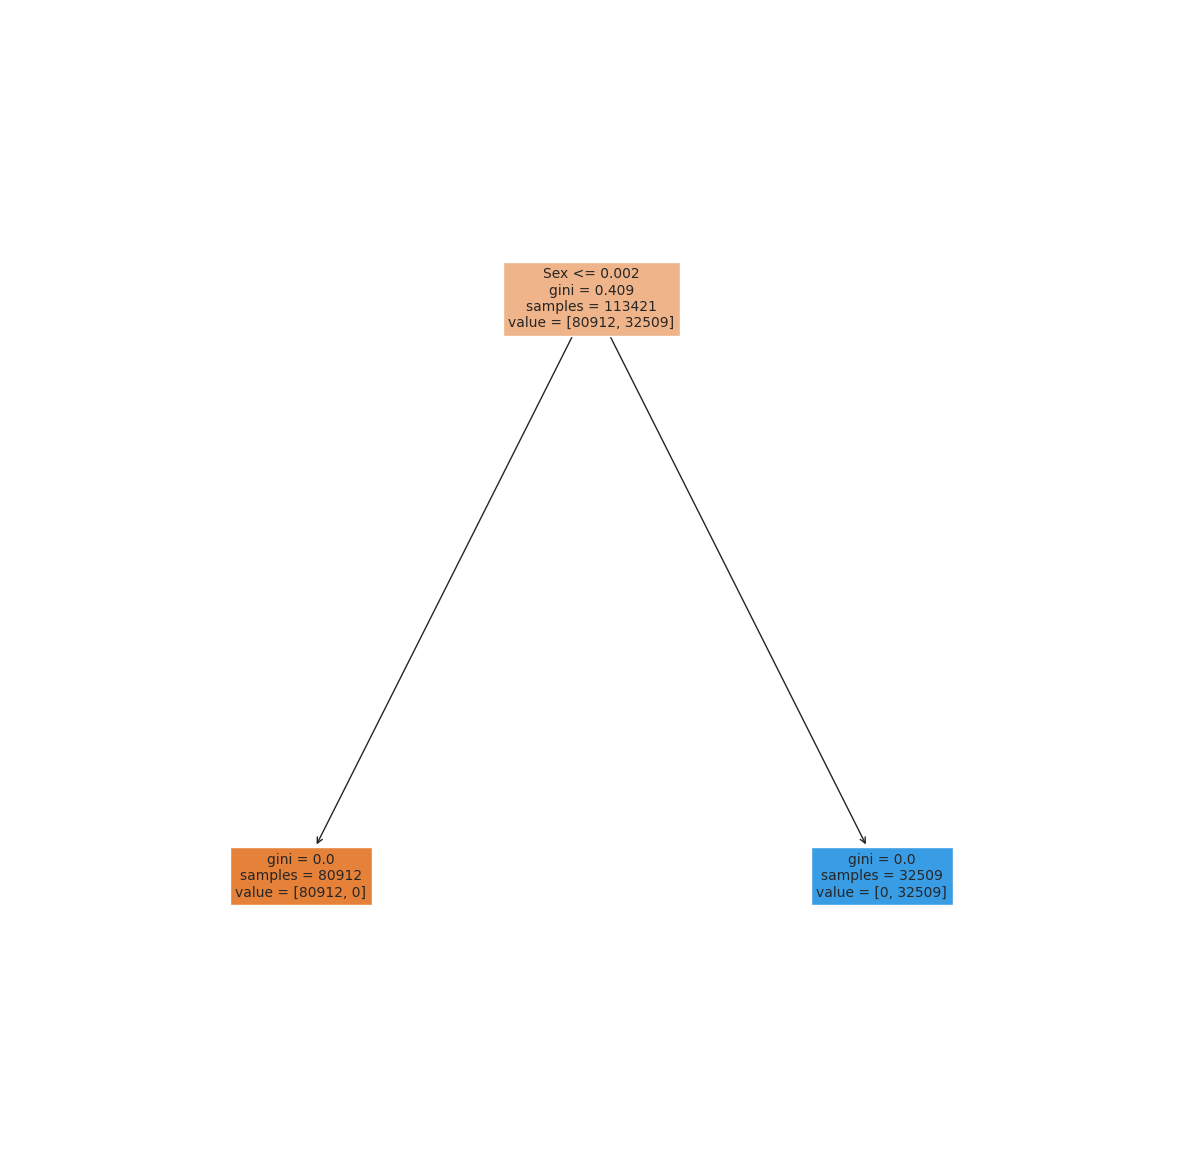

In [34]:
# Training the Model
decision_tree = DecisionTreeClassifier() # Initializing a decision tree classifier model
decision_tree.fit(X_train, y_train) # Fitting to the training data.
y_pred_dt = decision_tree.predict(X_test) # Using the trained model to predict the target variable for the test data. 

# Evaluating the model
print("Decision Tree Classifier")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt)) # Provides precision, recall, and F1-score for each class.
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt)) # Shows the number of true positives, false positives, true negatives, and false negatives.
print("Accuracy:", accuracy_score(y_test, y_pred_dt)) # Measures the overall accuracy of the model.

# Cross Validation
cross_val_acc = cross_val_score(decision_tree, X, y, cv=10, scoring='accuracy') # 10-fold cross-validation, where the data is split into 10 parts, and the model is trained and validated 10 times.
print("Cross Validation Accuracy: %.2f%%" % (cross_val_acc.mean() * 100)) # helps assess how well the model generalizes to unseen data

# Plotting the Decision Tree
plt.figure("Decision Tree Classifier", figsize=[15,15])
plot_tree(decision_tree, filled=True, feature_names=my_df_encoded.columns, fontsize=10)
plt.show()


<div align="center" style="font-size:14px;">
  <h2>Linear regression</h2>
</div>

**Linear Regression** is one of the simplest and most commonly used machine learning models for predictive analysis. It models the relationship between a dependent variable and one or more independent variables using a linear equation. The goal is to find the best-fit line that minimizes the sum of squared differences between the observed and predicted values.

In [35]:
linear_regression = LinearRegression() # Initializing a linear regression model
linear_regression.fit(X_train, y_train) # Training the model using the training data (X_train) and its corresponding labels (y_train). The model learns the coefficients of the linear equation during this step.
y_train_pred_linr = linear_regression.predict(X_train) # Using the trained model to predict the target variable for the training data.
y_test_pred_linr = linear_regression.predict(X_test) # Uses the trained model to predict the target variable for the test data.

print(y_train_pred_linr) 
print(y_test_pred_linr)

[0.22015035 0.23300908 0.28508851 ... 0.30545362 0.24927444 0.55603073]
[ 0.26411567 -0.28141026  0.21656039 ...  0.20692204  0.18939142
  0.27618221]


### Evaluation of model performance


In [36]:
# MSE measures the average of the squares of the errors, i.e the average squared difference between the actual and predicted values.
linr_train_mse = mean_squared_error(y_train, y_train_pred_linr) # Calculates the Mean Squared Error (MSE) for the training data. 
# R² is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by the independent variables.
linr_train_r2 = r2_score(y_train, y_train_pred_linr) # Calculates the R-squared (R²) score for the training data. 

linr_test_mse = mean_squared_error(y_test, y_test_pred_linr) # Calculates the MSE score for the test data. 
linr_test_r2 = r2_score(y_test, y_test_pred_linr) # Calculates the R-squared (R²) score for the test data. 

linr_results=pd.DataFrame(['Linear regression', linr_train_mse, linr_train_r2, linr_test_mse, linr_test_r2]).transpose() # Creating a data frame to store and display the evaluation metrics.
linr_results.columns = ('Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2') # Setting the column names
linr_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,0.166695,0.184748,0.172453,0.162969


<div align="center" style="font-size:14px;">
  <h2>Logistic regression</h2>
</div>

**Logistic regression** is a statistical method for binary classification problems and analyzing a dataset in which there are one or more independent variables that determine an outcome. The outcome is measured with a dichotomous variable. It estimates the probability that an instance belongs to a particular class and makes predictions based on a decision boundary.

In [37]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000) # Initializes a logistic regression model. The random_state parameter ensures reproducibility, and max_iter=1000 sets the maximum number of iterations for the solver.
logistic_regression.fit(X_train, y_train)
y_pred_logr = logistic_regression.predict(X_test)

# Evaluate the model
print("Logistic Regression")
print("Classification Report:")
print(classification_report(y_test, y_pred_logr)) # Prints a detailed classification report, which includes precision, recall, f1-score, and support for each class.
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logr)) # Prints the confusion matrix, which shows the number of true positive, true negative, false positive, and false negative predictions.
print("Accuracy:", accuracy_score(y_test, y_pred_logr)) # Prints the accuracy of the model, which is the ratio of correctly predicted instances to the total instances.

# Cross Validation
cross_val_acc = cross_val_score(logistic_regression, X, y, cv=10, scoring='accuracy') # Performs 10-fold cross-validation on the dataset (X, y). The scoring='accuracy' parameter specifies that I am interested in the accuracy score.
print("Cross Validation Accuracy: %.2f%%" % (cross_val_acc.mean() * 100)) # Computes the mean cross-validation accuracy and multiplies it by 100 to convert it to a percentage.

Logistic Regression
Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.99      0.84     20124
        True       0.72      0.09      0.16      8232

    accuracy                           0.73     28356
   macro avg       0.72      0.54      0.50     28356
weighted avg       0.72      0.73      0.64     28356

Confusion Matrix:
[[19836   288]
 [ 7501   731]]
Accuracy: 0.7253138665538158
Cross Validation Accuracy: 78.48%


<div align="center" style="font-size:14px;">
  <h2>Random Forest Classification</h2>
</div>

**Random Forest** is a learning method that builds multiple decision trees, each trained on a random subset of the training data and merges their outputs to improve the predictive performance and control overfitting. It can be used for both classification and regression tasks. For classification tasks (if the dependent variable is categorical), it predicts the mode of the classes, and for regression tasks (if the dependent variable is quantitative), it indicates the mean of the trees. Random Forest usually provides high accuracy and is robust to noise and overfitting.

In [38]:
# Train Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

# Evaluate the model
print("Random Forest Classifier")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Cross Validation
cross_val_acc = cross_val_score(random_forest, X, y, cv=10, scoring='accuracy')
print("Cross Validation Accuracy: %.2f%%" % (cross_val_acc.mean() * 100))


Random Forest Classifier
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20124
        True       1.00      1.00      1.00      8232

    accuracy                           1.00     28356
   macro avg       1.00      1.00      1.00     28356
weighted avg       1.00      1.00      1.00     28356

Confusion Matrix:
[[20124     0]
 [    0  8232]]
Accuracy: 1.0
Cross Validation Accuracy: 100.00%


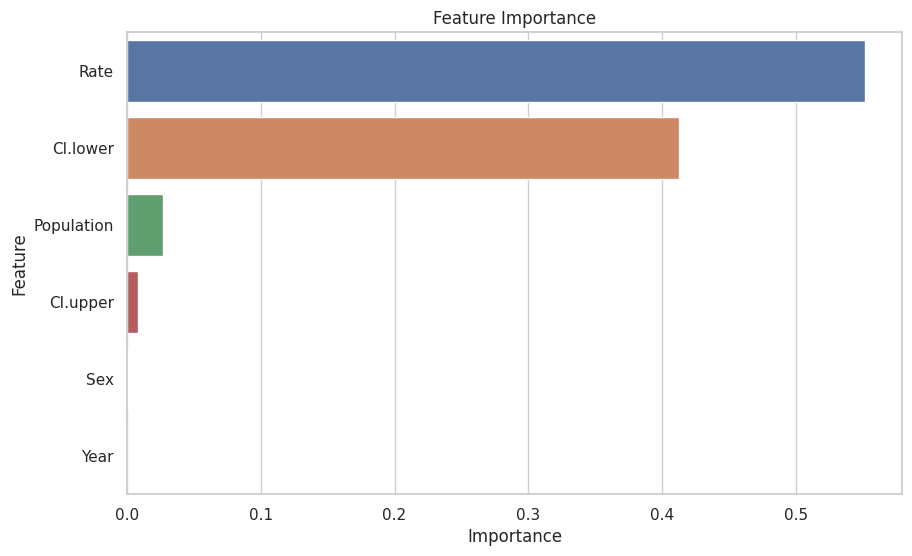

In [39]:
# Get feature importances
importances = random_forest.feature_importances_ # Provides an array of importance scores for each feature, to tell us how important each feature is for the predictions made by the model. 
indices = np.argsort(importances)[::-1] # sorts the indices of the importances array in descending order.

# Create a DataFrame for plotting
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

<div align="center" style="font-size:14px;">
  <h2>Gradient Boosting Classification</h2>
</div>

**Gradient Boosting Classification** is an ensemble machine learning technique (combining the predictions of multiple models to create a stronger model) used for classification tasks. It builds a strong classifier by combining multiple weak classifiers, typically decision trees, in a sequential manner. Each subsequent tree focuses on correcting the errors made by the previous trees. The goal is to minimize the loss function, which measures the difference between the actual and predicted values.

In [40]:
# Train Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train, y_train)
y_pred_gbc = gradient_boosting.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classifier")
print("Classification Report:")
print(classification_report(y_test, y_pred_gbc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))
print("Accuracy:", accuracy_score(y_test, y_pred_gbc))

# Cross Validation
cross_val_acc = cross_val_score(gradient_boosting, X, y, cv=10, scoring='accuracy')
print("Cross Validation Accuracy: %.2f%%" % (cross_val_acc.mean() * 100))

Gradient Boosting Classifier
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20124
        True       1.00      1.00      1.00      8232

    accuracy                           1.00     28356
   macro avg       1.00      1.00      1.00     28356
weighted avg       1.00      1.00      1.00     28356

Confusion Matrix:
[[20124     0]
 [    0  8232]]
Accuracy: 1.0
Cross Validation Accuracy: 100.00%


<div align="center" style="font-size:14px;">
  <h2>Gaussian Naive Bayes</h2>
</div>

**Gaussian Naive Bayes (GNB)** is a probabilistic classifier based on Bayes' Theorem with the assumption of independence between every pair of features. It is particularly suited for continuous data which follows a Gaussian (normal) distribution. This makes it different from other variations of Naive Bayes which are designed for categorical data. Training involves calculating the mean and standard deviation of each feature for each class. Prediction uses these statistics to compute the probability of each class given the feature values.

In [41]:
# Instantiate the Gaussian Naive Bayes classifier
g_naive_bayes = GaussianNB()
# Fit the model on the training data and predict on it
y_pred_nb = g_naive_bayes.fit(X_train, y_train).predict(X_test)
print("Gaussian Naive Bayes")
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred_nb).sum()))

print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))


Gaussian Naive Bayes
Number of mislabeled points out of a total 28356 points : 7577
Accuracy: 0.7327902383975173
Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.99      0.84     20124
        True       0.77      0.11      0.20      8232

    accuracy                           0.73     28356
   macro avg       0.75      0.55      0.52     28356
weighted avg       0.74      0.73      0.65     28356

Confusion Matrix:
[[19836   288]
 [ 7289   943]]


<div align="center" style="font-size:14px;">
  <h2>Building a Neural Network</h2>
</div>

**Neural networks** are a set of algorithms, modeled loosely after the human brain, that are designed to recognize patterns. They interpret sensory data through a kind of machine perception, labeling, and clustering of raw input. The architecture of a neural network consists of layers of neurons, each layer transforming the data and passing it to the next layer (an input layer, hidden layers, and an output layer).

In [42]:
# Create a pipeline with StandardScaler and Perceptron
perceptron_pipe = make_pipeline(StandardScaler(), Perceptron(max_iter=1000, random_state=42))
perceptron_pipe.fit(X_train, y_train)
y_pred_nn = perceptron_pipe.predict(X_test)

# Evaluate the model
print("Perceptron Neural Network Results:")
print("Classification Report:")
print(classification_report(y_test, y_pred_nn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))
perceptron_score = perceptron_pipe.score(X_test, y_test)
print("Score:", perceptron_score)

# Cross-validation
cross_val_acc_perceptron = cross_val_score(perceptron_pipe, X, y, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
print("\nCross-Validation Accuracy: %.2f%%" % (cross_val_acc_perceptron.mean() * 100))



Perceptron Neural Network Results:
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.96      0.98     20124
        True       0.92      0.99      0.95      8232

    accuracy                           0.97     28356
   macro avg       0.96      0.98      0.97     28356
weighted avg       0.97      0.97      0.97     28356

Confusion Matrix:
[[19371   753]
 [   45  8187]]
Score: 0.97185780787135

Cross-Validation Accuracy: 96.71%


<div align="center" style="font-size:14px;">
  <h1>Comparing the models </h1>
</div>

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  Model  Accuracy  Precision    Recall  F1 Score
0         Decision Tree  1.000000   1.000000  1.000000  1.000000
1         Random Forest  1.000000   1.000000  1.000000  1.000000
2     Linear Regression  0.750317   0.789455  0.750317  0.682247
3   Logistic Regression  0.725314   0.723218  0.725314  0.639101
4     Gradient Boosting  1.000000   1.000000  1.000000  1.000000
5  Gaussian Naive Bayes  0.732790   0.741373  0.732790  0.653742
6        Neural Network  0.971858   0.973903  0.971858  0.972186


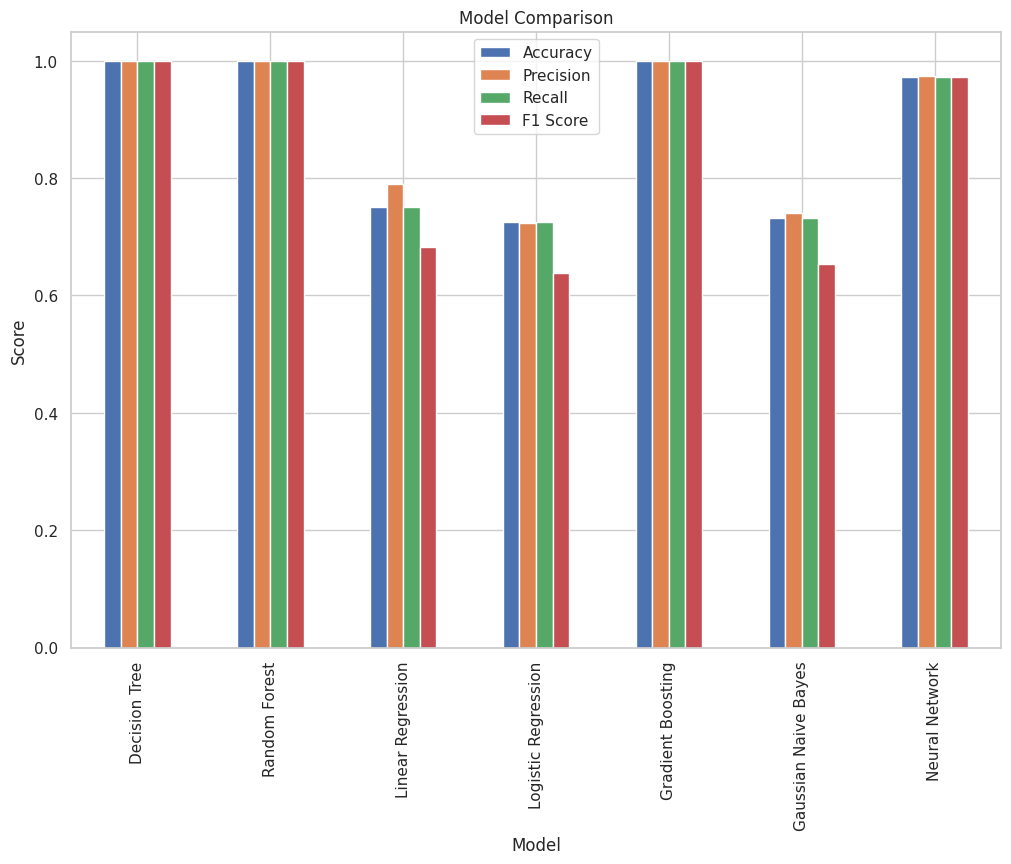

In [43]:
# I create a dictionary which stores the different trained models. Each key is a model name, and each value is the corresponding model object.
models = {
    'DecisionTree': decision_tree, 
    'RandomForest': random_forest, 
    'LinearRegression': linear_regression, 
    'LogisticRegression': logistic_regression, 
    'GradientBoosting': gradient_boosting, 
    'GaussianNB': g_naive_bayes,
    'Neural Network': perceptron_pipe
}

# I make another dictionary which stores the predictions made by each model on the test dataset. Each key is a model name, and each value is the array of predicted values.
predictions = {
    'Decision Tree': y_pred_dt, 
    'Random Forest': y_pred_rf, 
    'Linear Regression': y_test_pred_linr, 
    'Logistic Regression': y_pred_logr, 
    'Gradient Boosting': y_pred_gbc,
    'Gaussian Naive Bayes': y_pred_nb,
    'Neural Network': y_pred_nn
}

# Since Linear Regression predicts continuous values, these need to be converted to class labels to be comparable with other models.
predictions['Linear Regression'] = np.round(predictions['Linear Regression']).astype(int)

# For each model, calculate the accuracy, precision, recall, and F1 score. Store these metrics in a list of dictionaries.
results = []
for model_name, y_pred in predictions.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    # Convert the list of dictionaries to a data frame for easier manipulation and visualization.
results_df = pd.DataFrame(results)

# Print the DataFrame
print(results_df)

# Plot the results
results_df.set_index('Model', inplace=True) # Setting the index of the data frame to the model names for better visualization.
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.show()


### References

Source of the dataset that is used as input: Kaggle (https://www.kaggle.com/datasets/jahaidulislam/infectious-disease-2001-2014)

Video that helped me with some basics of the models: https://www.youtube.com/watch?v=7eh4d6sabA0

I got some ideas from the Scikit-learn Documentation https://scikit-learn.org/stable/ 
More specifically for the model for Naive Bayes https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes

I also used Google to find some definitions and help. 